# Домашнее задание № 9

### Задание 1 (10 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs_torch.ipynb

На датасете lenta_sample.ru  дообучите две модели - modernbert-base (из семинара) и rumodernbert-base (https://huggingface.co/deepvk/RuModernBERT-base). Оцените разницу в качестве сравнив поклассовые метрики (classification_report)

Для обоих моделей качество должно быть >0.10 по f-мере (прогоните несколько экспериментов если у вас получаются нули, изменяя параметры).
Также для обоих моделей попробуйте дообучать модель и целиком и дообучать только последний слой. 
Для RuModernBERT дополнительно сравните модель, которая использует первый вектор (cls токен, как в семинаре), так и усредненный вектор по всем hidden_state, который выдает bert. 




In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.5.0


In [12]:
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

from tqdm.auto import tqdm
import numpy as np
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [13]:
data = pd.read_csv('/kaggle/input/lenta-sample/lenta_sample.csv')

In [14]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):

        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)

        self.MAX_LEN = MAX_LEN
        self.length = len(texts)

        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [15]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
            
    return np.mean(epoch_f1)# / len(iterator)

In [16]:
def predict(model, iterator):

    preds = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:
            predictions = model(texts.to(device)).squeeze()
            ys = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            preds.extend(ys)

    return preds

In [17]:
class CLF(nn.Module):
    
    def __init__(self, pretrained_model, num_classes):
        super().__init__()          
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        #
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes) 
        self.act = nn.LogSoftmax(1) 
        
    def forward(self, texts):
        
        mask = (texts != tokenizer.pad_token_id).long()
        
        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        # берем самое первое состояние и применяем к нему линейный слой и активацию
        dense_outputs=self.fc(self.drop(hidden[:,0] ))
        outputs=self.act(dense_outputs)
        
        return outputs

In [18]:
MAX_LEN = 512

In [19]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [20]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

### ModernBERT

Без заморозки

In [ ]:
pip install -U transformers>=4.48

In [21]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id)

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [22]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [25]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [26]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.09583333333333333
1
Eval -  0.03333333333333333
2
Eval -  0.12916666666666665
3
Eval -  0.09583333333333333
4
Eval -  0.09375
5
Eval -  0.15833333333333333
6
Eval -  0.16250000000000003
7
Eval -  0.2583333333333333
8
Eval -  0.3520833333333333
9
Eval -  0.39375
10
Eval -  0.35625000000000007
11
Eval -  0.38750000000000007
12
Eval -  0.38750000000000007
13
Eval -  0.25625000000000003
14
Eval -  0.22708333333333333
15
Eval -  0.3520833333333333
16
Eval -  0.22708333333333333
17
Eval -  0.22500000000000003
18
Eval -  0.3833333333333333
19
Eval -  0.39166666666666666
20
Eval -  0.29166666666666663
21
Eval -  0.29583333333333334
22
Eval -  0.25625000000000003
23
Eval -  0.29583333333333334
24
Eval -  0.25416666666666665
25
Eval -  0.26250000000000007
26
Eval -  0.22916666666666666
27
Eval -  0.23125000000000004
28
Eval -  0.22500000000000003
29
Eval -  0.22500000000000003


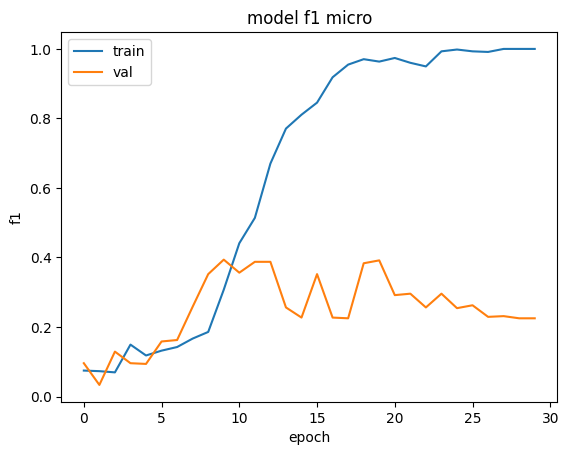

In [27]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [29]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           2       1.00      1.00      1.00         1
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         3
          12       0.25      0.50      0.33         2
          13       0.75      0.75      0.75         4
          16       0.00      0.00      0.00         4

    accuracy                           0.23        31
   macro avg       0.20      0.26      0.22        31
weighted avg       0.19      0.23      0.20        31



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

С заморозкой

In [30]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

for param in model_bert.parameters():
    param.requires_grad = False

In [31]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [33]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [34]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.12916666666666665
1
Eval -  0.16041666666666665
2
Eval -  0.22708333333333333
3
Eval -  0.19375000000000003
4
Eval -  0.22708333333333333
5
Eval -  0.19375000000000003
6
Eval -  0.29375000000000007
7
Eval -  0.32291666666666663
8
Eval -  0.2895833333333333
9
Eval -  0.22500000000000003
10
Eval -  0.2895833333333333
11
Eval -  0.29166666666666663
12
Eval -  0.38958333333333334
13
Eval -  0.3208333333333333
14
Eval -  0.38750000000000007
15
Eval -  0.36041666666666666
16
Eval -  0.38541666666666663
17
Eval -  0.35625000000000007
18
Eval -  0.36041666666666666
19
Eval -  0.36041666666666666
20
Eval -  0.39375
21
Eval -  0.42291666666666666
22
Eval -  0.38541666666666663
23
Eval -  0.3833333333333333
24
Eval -  0.38541666666666663
25
Eval -  0.35416666666666663
26
Eval -  0.42083333333333334
27
Eval -  0.3833333333333333
28
Eval -  0.36041666666666666
29
Eval -  0.38125000000000003


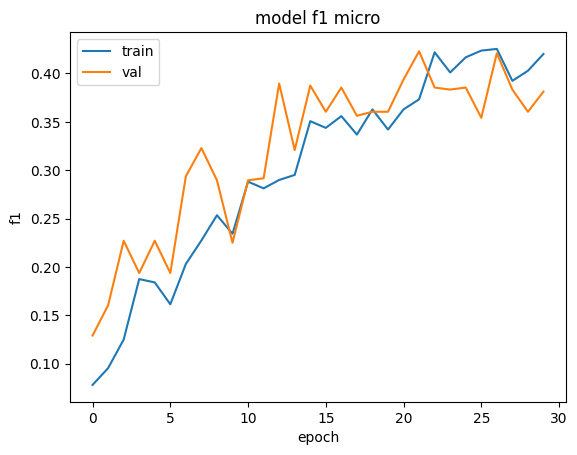

In [35]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [37]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.50      0.50      0.50         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         4
           9       0.67      1.00      0.80         2
          10       0.00      0.00      0.00         3
          11       0.50      0.67      0.57         3
          12       1.00      0.50      0.67         2
          13       0.38      0.75      0.50         4
          16       0.40      0.50      0.44         4

    accuracy                           0.39        31
   macro avg       0.27      0.30      0.27        31
weighted avg       0.32      0.39      0.34        31



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

### RuModernBERT

Без заморозки

In [38]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_ru = AutoModel.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.75M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [39]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_ru, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [41]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [42]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.18958333333333333
1
Eval -  0.12916666666666665
2
Eval -  0.09583333333333333
3
Eval -  0.22708333333333333
4
Eval -  0.38125000000000003
5
Eval -  0.2583333333333333
6
Eval -  0.35000000000000003
7
Eval -  0.3833333333333333
8
Eval -  0.48125000000000007
9
Eval -  0.48541666666666666
10
Eval -  0.38541666666666663
11
Eval -  0.39166666666666666
12
Eval -  0.48541666666666666
13
Eval -  0.48333333333333334
14
Eval -  0.38958333333333334
15
Eval -  0.5437500000000001
16
Eval -  0.5520833333333333
17
Eval -  0.5458333333333334
18
Eval -  0.5479166666666666
19
Eval -  0.55
20
Eval -  0.5541666666666667
21
Eval -  0.5520833333333333
22
Eval -  0.5520833333333333
23
Eval -  0.55
24
Eval -  0.5520833333333333
25
Eval -  0.5520833333333333
26
Eval -  0.55
27
Eval -  0.55
28
Eval -  0.5479166666666666
29
Eval -  0.5520833333333333


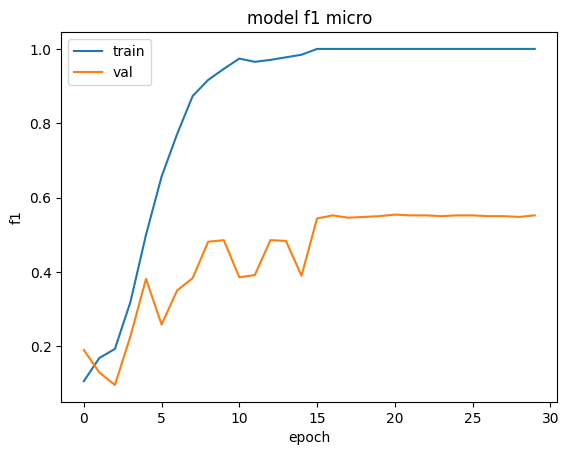

In [43]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [45]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.50      1.00      0.67         1
           8       0.67      0.50      0.57         4
           9       1.00      1.00      1.00         2
          10       0.33      0.33      0.33         3
          11       1.00      0.67      0.80         3
          12       1.00      0.50      0.67         2
          13       1.00      0.50      0.67         4
          15       0.00      0.00      0.00         0
          16       0.40      0.50      0.44         4

    accuracy                           0.55        31
   macro avg       0.56      0.49      0.50        31
weighted avg       0.69   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

С заморозкой

In [50]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_ru = AutoModel.from_pretrained(model_id)

for param in model_ru.parameters():
    param.requires_grad = False

In [51]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_ru, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [53]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [54]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.09791666666666667
1
Eval -  0.09791666666666667
2
Eval -  0.03125
3
Eval -  0.03333333333333333
4
Eval -  0.06458333333333333
5
Eval -  0.09375
6
Eval -  0.03125
7
Eval -  0.03333333333333333
8
Eval -  0.09791666666666667
9
Eval -  0.09583333333333333
10
Eval -  0.0625
11
Eval -  0.03125
12
Eval -  0.16041666666666665
13
Eval -  0.16250000000000003
14
Eval -  0.09583333333333333
15
Eval -  0.03125
16
Eval -  0.19375000000000003
17
Eval -  0.06666666666666667
18
Eval -  0.09791666666666667
19
Eval -  0.16458333333333333
20
Eval -  0.09583333333333333
21
Eval -  0.09583333333333333
22
Eval -  0.13125000000000003
23
Eval -  0.16458333333333333
24
Eval -  0.16041666666666665
25
Eval -  0.03333333333333333
26
Eval -  0.16041666666666665
27
Eval -  0.06666666666666667
28
Eval -  0.16250000000000003
29
Eval -  0.10000000000000002


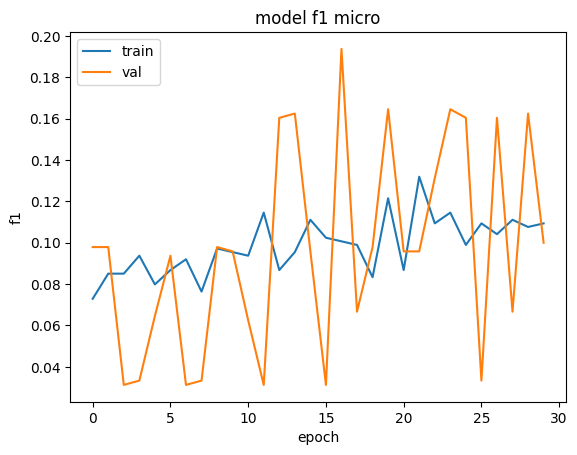

In [55]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [56]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [57]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           3       0.04      1.00      0.08         1
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         4
           9       0.25      0.50      0.33         2
          10       0.00      0.00      0.00         3
          11       0.25      0.33      0.29         3
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         4

    accuracy                           0.10        31
   macro avg       0.04      0.14      0.05        31
weighted avg       0.04      0.10      0.05        31



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Усредненный вектор по всем hidden_state

In [58]:
class CLF(nn.Module):
    
    def __init__(self, pretrained_model, num_classes):
        super().__init__()          
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        #
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes) 
        self.act = nn.LogSoftmax(1) 
        
    def forward(self, texts):
        
        mask = (texts != tokenizer.pad_token_id).long()
        
        hidden = self.pretrained_model(texts, attention_mask=mask).last_hidden_state
        hidden_avg = hidden.mean(dim=1)

        dense_outputs=self.fc(self.drop(hidden_avg))
        outputs=self.act(dense_outputs)
        
        return outputs

In [59]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_ru = AutoModel.from_pretrained(model_id)

In [60]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_ru, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [62]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [63]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.5145833333333334
1
Eval -  0.7125000000000001
2
Eval -  0.7104166666666667
3
Eval -  0.5770833333333334
4
Eval -  0.7395833333333333
5
Eval -  0.6770833333333333
6
Eval -  0.6812500000000001
7
Eval -  0.7750000000000001
8
Eval -  0.7083333333333333
9
Eval -  0.6416666666666666
10
Eval -  0.7083333333333333
11
Eval -  0.675
12
Eval -  0.7437500000000001
13
Eval -  0.6770833333333333
14
Eval -  0.70625
15
Eval -  0.6791666666666667
16
Eval -  0.6479166666666667
17
Eval -  0.6500000000000001
18
Eval -  0.6104166666666666
19
Eval -  0.6729166666666666
20
Eval -  0.675
21
Eval -  0.7416666666666667
22
Eval -  0.7479166666666667
23
Eval -  0.7437500000000001
24
Eval -  0.7395833333333333
25
Eval -  0.7729166666666667
26
Eval -  0.78125
27
Eval -  0.7729166666666667
28
Eval -  0.7729166666666667
29
Eval -  0.7791666666666667


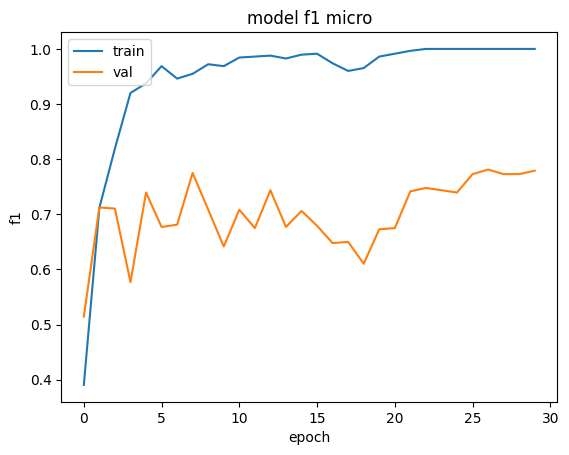

In [64]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [65]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [66]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         2
           5       0.33      1.00      0.50         1
           7       0.50      1.00      0.67         1
           8       0.50      0.25      0.33         4
           9       1.00      1.00      1.00         2
          10       1.00      0.33      0.50         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         2
          13       1.00      0.75      0.86         4
          16       0.67      1.00      0.80         4

    accuracy                           0.77        31
   macro avg       0.82      0.85      0.79        31
weighted avg       0.82      0.77      0.76        31

